## Introduction

I use the Enron Corpus, found here: https://www.kaggle.com/wcukierski/enron-email-dataset, to try to replicate the analysis from this paper:

Volodymyr Miz, Benjamin Ricaud, Kirell Benzi, and Pierre Vandergheynst. 2019. Anomaly detection in the dynamics of web and social networks. In Proceedings of May 13-17 (TheWebConf 2019). , 10 pages. https://doi.org/10.475/123_4

They were able to detect four periods of anamoly within the corpus data by treating the social network of email communications as a Hopfield Memory Network. They start by building a graph of email addresses as nodes and emails sent as edges. The attributes of the graph they built are described more specifically here:
https://zenodo.org/record/1342353#.Xap5medKjMJ

In order to better understand how to clean the data I also followed:

Shetty, Jitesh & Adibi, Jafar. (2004). The Enron email dataset database schema and brief statistical report. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.296.9477&rep=rep1&type=pdf

Table of Contents:

I. Attempt to duplicate the graph built by Miz, Ricaud, Benzi, Vandergheynst (2019), now called official data.

II. Attempt to duplicate the spatio-temporal analysis that they perform to catch the anomalies. 

III. Analysis of the activity of the anomalous clusters

## 0. Import Libraries

In [2]:
# Libraries for data analysis
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import re
from datetime import datetime
from collections import defaultdict 

import networkx as nx
from nxviz import CircosPlot

import random
from operator import sub
import math
import statistics
import ast

# I. Duplicate Graph

In [2]:
# Defining a function to take the message column from the Dataframe of emails and extract three Pandas Series containing: the date of the email, the addresses that the email is from, the addresses that the email is sent to
# The data, from, and to data of the emails is what we need to generate the graph of our social network
def get_date_from_to(Series):
    # Generate three empty Pandas Series to hold the data we will output
    result_date = pd.Series(index=Series.index)
    result_from = pd.Series(index=Series.index)
    result_to = pd.Series(index=Series.index)
    # Since this process takes some time with the full data, this is a tracking function 
    for row, message in enumerate(Series):
        if row % 10000 == 0:
            print(f'Row: {row} starting at {datetime.now()}.')
        # The message data is fairly simple and split predictable by lines
        message_words = message.split('\n')
        # Data is generally in the second line
        if 'Date:' in message_words[1]:
            result_date[row] = message_words[1].replace('Date:', '')
        else:
            result_date[row] = np.nan
        # From addresses are generally in the third line, below is a regex to find email addresses
        if 'From:' in message_words[2]:
            result_from[row] = re.findall('[\w\.-]+@[\w\.-]+\.\w+', message_words[2])
        else:
            result_from[row] = np.nan
        # To addresses are generally in the fourth line, below is a regex to find email addresses
        if 'To:' in message_words[3]:
            result_to[row] = re.findall('[\w\.-]+@[\w\.-]+\.\w+', message_words[3]) 
        else:
            result_to[row] = np.nan
    # We convert the data times to the format of days after Jan 1, 1999 consistent with how data is stored by Miz, Ricaud, Benzi, Vandergheynst (2019).
    print('Converting Dates.')
    result_date = pd.to_datetime(result_date)
    result_date = result_date - datetime(1999,1,1) # As in the paper, will drop values before Jan 1, 1999
    return result_date, result_from, result_to

In [3]:
# This generates a graph with nodes for email addresses, edges if an email is sent once, and a time lapse dictionary associated with each node capturing how many emails were sent on what days
def gen_graph(date_from_to):
    G = nx.Graph()
    for index, row in date_from_to.iterrows():
        for sender in row.senders:
            if sender not in G:
                G.add_node(sender)
            for recipient in row.recipients:
                if recipient not in G:
                    G.add_node(recipient)
                if not(G.has_edge(sender, recipient)):
                    G.add_edge(sender, recipient)
                G.node[sender][row.date.days] = G.node[sender].get(row.date.days, 0) + 1
    return G

In [4]:
def map_nodes_to_int(G):
    nodes = G.nodes
    mapping = {}
    node_index = 0
    for node in nodes:
        mapping[node] = node_index
        node_index+=1
    H = nx.relabel_nodes(G, mapping)
    return H, mapping  

In [6]:
# Miz, Ricaud, Benzi, Vandergheynst (2019) filtered out any email addresses that didn't send more than 3 emails
def filter_graph_down(G, min_emails=4):
    nodes_to_keep = []
    nodes = G.nodes
    for key, values in nodes.items():
        if sum(values.values()) >= min_emails:
            nodes_to_keep.append(key)
    sub_G = G.subgraph(nodes_to_keep)
    return sub_G

In [5]:
# Reading in emails
emails = pd.read_csv('emails.csv')

In [9]:
# Dropping dups and auto created emails
# Generating table of dates, senders, receivers
emails_nodups = emails[~emails.file.str.contains('discussion_thread')]
emails_noautos = emails_nodups[~emails_nodups.file.str.contains('all_documents')]
emails_noautos = emails_noautos.reset_index()
date_from_to = pd.DataFrame()
date_from_to['date'], date_from_to['senders'], date_from_to['recipients'] = get_date_from_to(emails_noautos.message) 
print(len(date_from_to))

Row: 0 starting at 2019-11-19 14:53:53.829113.
Row: 10000 starting at 2019-11-19 14:53:54.887632.
Row: 20000 starting at 2019-11-19 14:53:55.942886.
Row: 30000 starting at 2019-11-19 14:53:56.442161.
Row: 40000 starting at 2019-11-19 14:53:57.133102.
Row: 50000 starting at 2019-11-19 14:53:58.193815.
Row: 60000 starting at 2019-11-19 14:53:58.761066.
Row: 70000 starting at 2019-11-19 14:53:59.760541.
Row: 80000 starting at 2019-11-19 14:54:00.186859.
Row: 90000 starting at 2019-11-19 14:54:00.736105.
Row: 100000 starting at 2019-11-19 14:54:01.146841.
Row: 110000 starting at 2019-11-19 14:54:01.649933.
Row: 120000 starting at 2019-11-19 14:54:02.440419.
Row: 130000 starting at 2019-11-19 14:54:03.123122.
Row: 140000 starting at 2019-11-19 14:54:03.575431.
Row: 150000 starting at 2019-11-19 14:54:04.095484.
Row: 160000 starting at 2019-11-19 14:54:04.594701.
Row: 170000 starting at 2019-11-19 14:54:05.261858.
Row: 180000 starting at 2019-11-19 14:54:05.858063.
Row: 190000 starting at 20

In [10]:
# Filtering out naan entries
# Filtering out entries before Jan 1, 1999
# Filtering out entries after July 31, 2002
print(len(date_from_to))
date_from_to.dropna(inplace=True)
date_from_to = date_from_to[date_from_to.date >= pd.Timedelta(0)]
date_from_to = date_from_to[date_from_to.date <= pd.Timedelta(days=1448)] # Dropping emails after 31 July 2002
print(len(date_from_to))

330689
313191


In [113]:
# Generating initial Graph
G_init = gen_graph(date_from_to)

In [114]:
# Filtering out nodes with 3 or fewer emails sent during time period
G_emails = filter_graph_down(G_init, min_emails=4) 

34897
87780


In [115]:
G_mapped, mapping = map_nodes_to_int(G_emails)

In [116]:
print(nx.number_of_nodes(G_mapped))
print(nx.number_of_edges(G_mapped))

7125
47097


The graph generated by Miz, Ricaud, Benzi, Vandergheynst (2019), had 6600 nodes and 50,897 edges. I wasn't able to perfectly duplicate this result, but in order to get close I had to do things like drop automatically sent emails and I had to drop some duplicated emails as in Shetty, Adibi (2004). The day numbers differ slightly between our two sets as well (by 3 days), I'm not sure why this is. In the next part I will use both my data and the data provided by Miz, Ricaud, Benzi, Vandergheynst (2019) to perform the ML analysis. 

Note: Turns out that the reason my data is off is because I kept all emails that either sent or received 3 emails. Miz, Ricaud, Benzi, Vandergheynst (2019) only kept nodes that sent 3 emails. I'm going to use their data from now moving forward. But this was a good exercise. Below is their data.

In [3]:
nodes_df = pd.read_csv('nodes.csv', header=None, names=['node_dict'], index_col=0)
edges_df = pd.read_csv('edges.csv')
print(nodes_df.head())
print(edges_df.head())

                                           node_dict
0                                           {687: 6}
1  {1024: 1, 1089: 1, 1132: 1, 1100: 1, 1165: 1, ...
2                                   {611: 4, 612: 2}
3                         {1004: 2, 1005: 4, 967: 2}
4  {897: 3, 900: 1, 903: 1, 905: 1, 906: 1, 962: ...
   From    To  Count
0     0  1760      3
1     2  2692      6
2     3  2719      2
3     3  3118      2
4     3  5211      2


In [4]:
nodes_list = [(index, ast.literal_eval(row.node_dict)) for index, row in nodes_df.iterrows()]
edges_list = [(row.From, row.To) for index, row in edges_df.iterrows()]
print(nodes_list[:5])
print(edges_list[:5])

[(0, {687: 6}), (1, {1024: 1, 1089: 1, 1132: 1, 1100: 1, 1165: 1, 1075: 1, 1109: 1, 1081: 1, 1114: 1}), (2, {611: 4, 612: 2}), (3, {1004: 2, 1005: 4, 967: 2}), (4, {897: 3, 900: 1, 903: 1, 905: 1, 906: 1, 962: 1, 910: 1, 920: 6, 792: 3, 794: 1, 795: 2, 925: 3, 802: 1, 931: 3, 805: 1, 806: 1, 807: 1, 938: 1, 939: 1, 940: 1, 941: 1, 942: 1, 945: 1, 946: 1, 947: 3, 948: 4, 990: 1, 953: 1, 826: 1, 955: 6, 956: 11, 960: 1, 833: 2, 961: 5, 966: 1, 840: 1, 973: 5, 974: 6, 975: 6, 850: 3, 855: 1, 856: 3, 996: 1, 991: 3, 862: 1, 863: 3, 864: 1, 868: 1, 869: 3, 998: 3, 872: 1, 935: 1, 876: 11, 877: 2, 878: 3, 879: 1, 882: 4, 884: 5, 886: 4, 890: 3})]
[(0, 1760), (2, 2692), (3, 2719), (3, 3118), (3, 5211)]


In [5]:
# Creating graph with official data
# Note: I get 50 897 directed edges (number in their paper), but 40777 undirected edges
# since the following analysis uses undirected edges I go ahead with that
G_mapped = nx.Graph()
G_mapped.add_nodes_from(nodes_list)
G_mapped.add_edges_from(edges_list)
print(nx.number_of_nodes(G_mapped))
print(nx.number_of_edges(G_mapped))

6600
40777


# II. Implementing Algorithms from Paper

Miz, Ricaud, Benzi, Vandergheynst (2019) treats the social network of people sending emails at Enron as a graph where the nodes represent email addresses (that sent more than 3 emails during the time in question) and edges exist between email addresses if an email was ever sent between the email addresses. 

This graph (which represents a social network) is then treated like a memory network. Specifically the network is a Hopfield memory network using the Hebbian learning rule. A Hopfield network stores memories (and can be recalled in using partial informatino). The Hebbian rule creates memories when nodes (neurons) fire together, in this case an abnormal level of emailing is what is registered as a neuron firing.

Miz, Ricaud, Benzi, Vandergheynst (2019) go through 4 stages of when implementing the algorithm just described:

1) They extract features by finding abnormal bursts of emails from one person. These basically correspond in future steps to a "neuron firing" within the memory field.

2) They train Hopfield memory fields from those bursts using the Hebbian rule, which means connected people sending abnormally higher levels of emails together gets trained into the field as a "memorable event". A new Hopfield memory field is trained each month in this case, so they're attempting to learn new "memories" each month.

3) They explore the Hopfield memory fields from certain months and look for the largest connected subgraph from that memory field and treat that as a "memorable" co-occurence of abnormally high email behavior

4) They look at that subgraph of people and analyze their email volume to confirm that there is in fact an anomaly of emails during that time, this is compared to four events that happened in real life where higher email traffic would be expected

## II.a. Extract features and filter nodes

In [6]:
def gen_signal_array(G, t_min=0, t_max=1448):
    nodes = G.nodes(data=True)
    signal_array = np.zeros(shape=(len(nodes),t_max+1-t_min))
    for t in range(t_min, t_max+1):
        for node, data in nodes:
            signal_array[node][t-t_min] = data.get(t,0)
    return signal_array

In [7]:
def gen_means_and_stds(signal_array):
    means = np.apply_along_axis(np.mean, 0, signal_array)
    stds = np.apply_along_axis(np.std, 0, signal_array)
    return means, stds

In [814]:
# Keep only nodes that have 2 or more bursts
# Only keep activity that is anamolous (a burst)
def filter_potential_anomalies(G, t_min, t_max, burst_threshold, min_bursts):
    signal_array = gen_signal_array(G, t_min, t_max)
    means, stds = gen_means_and_stds(signal_array)
    nodes = G.nodes
    nodes_to_keep = []
    activity = {}
    for node, node_dict in nodes.items():
        bursts = 0
        activity_to_keep = {}
        #freq = 0
        total = 0
        for t in range(t_min, t_max+1):
            if node_dict.get(t,0)>0:
                total+=node_dict[t]
                #freq+=1
                #activity_to_keep[t] = node_dict[t]
        for t in range(t_min, t_max+1):
            if node_dict.get(t,0) > means[t-t_min] + stds[t-t_min]*burst_threshold:
                bursts+=1
                activity_to_keep[t] = node_dict[t]
        if bursts >= min_bursts:
            nodes_to_keep.append(node)
            activity[node] = dict([(k, v/total) for k,v in activity_to_keep.items()])
    #H=G.subgraph(nodes_to_keep)
    H = nx.Graph()
    H.add_nodes_from(G.subgraph(nodes_to_keep).nodes)
    H.add_edges_from(G.subgraph(nodes_to_keep).edges)
    nx.set_node_attributes(H, activity)
    return H

In [891]:
# December graph
G_dec = filter_potential_anomalies(G_mapped, t_min=330, t_max=361, burst_threshold=3, min_bursts=2)

In [892]:
print(nx.number_of_nodes(G_dec))
print(nx.number_of_edges(G_dec))

73
276


In [817]:
# April graph
G_apr = filter_potential_anomalies(G_mapped, t_min=818, t_max=848, burst_threshold=5, min_bursts=3)

In [818]:
print(nx.number_of_nodes(G_apr))
print(nx.number_of_edges(G_apr))

46
213


In [819]:
# May graph
G_may = filter_potential_anomalies(G_mapped, t_min=848, t_max=886, burst_threshold=5, min_bursts=3)

In [820]:
print(nx.number_of_nodes(G_may))
print(nx.number_of_edges(G_may))

89
557


In [938]:
# August graph
G_aug = filter_potential_anomalies(G_mapped, t_min=940, t_max=971, burst_threshold=6, min_bursts=3)

In [939]:
print(nx.number_of_nodes(G_aug))
print(nx.number_of_edges(G_aug))

55
190


In [823]:
G_aug.nodes(data=True)

NodeDataView({5635: {945: 0.0625, 955: 0.0625, 959: 0.0625, 960: 0.19791666666666666, 962: 0.0625, 966: 0.09375, 967: 0.125, 970: 0.20833333333333334}, 4: {947: 0.07894736842105263, 948: 0.10526315789473684, 955: 0.15789473684210525, 956: 0.2894736842105263}, 1540: {940: 0.06976744186046512, 941: 0.05232558139534884, 945: 0.046511627906976744, 946: 0.040697674418604654, 947: 0.029069767441860465, 948: 0.040697674418604654, 949: 0.0872093023255814, 952: 0.05813953488372093, 953: 0.06395348837209303, 954: 0.040697674418604654, 955: 0.05813953488372093, 959: 0.12790697674418605, 960: 0.029069767441860465, 962: 0.0755813953488372, 963: 0.023255813953488372, 966: 0.023255813953488372, 967: 0.029069767441860465, 968: 0.03488372093023256, 969: 0.05813953488372093}, 3078: {946: 0.12727272727272726, 947: 0.03636363636363636, 949: 0.05454545454545454, 952: 0.16363636363636364, 954: 0.05454545454545454, 960: 0.16363636363636364, 963: 0.05454545454545454, 966: 0.07272727272727272}, 3848: {942: 0.1

## II.b and c. Train Hopfield Network and extracting Largest Connected Component Subgraph

In [788]:
def train_hopfield(G, min_time, max_time, sparsity_parameter=0.5, forgetting_parameter=0):
    H = G.copy()
    edges = H.edges
    edge_weights = {}
    sim = {}
    for i, j in edges:
        node_dict_i = G.nodes(data=True)[i]
        node_dict_j = G.nodes(data=True)[j]
        edge_weights[(i,j)] = 0
        # Train by stepping through time and use Hebbian learning rule (using the similarity function defined)
        for t in range(min_time, max_time+1):
            activities = (node_dict_i.get(t,0), node_dict_j.get(t,0))
            if activities == (0,0):
                sim[(i,j,t)] = 0
            else:
                sim[(i,j,t)] = min(activities)/max(activities)
            if sim[(i,j,t)] > sparsity_parameter:
                edge_weights[(i,j)] += sim[(i,j,t)]
            else:
                edge_weights[(i,j)] -forgetting_parameter*sim[(i,j,t)]
    nx.set_edge_attributes(H, name='weight', values=edge_weights)
    return H

In [875]:
# Filter out edges with low weight
def filter_edges_by_weight(G, weight_limit=0):
    H = G.copy()
    to_remove = []
    edges = H.edges(data=True)
    for i, j, data in edges:
        if data['weight'] <= weight_limit:
            to_remove.append((i,j))
    H.remove_edges_from(to_remove)
    return H

In [893]:
# Training the Hopfield network for December 1999 (first anomaly)
G_trained_dec = train_hopfield(G_dec, min_time=330, max_time=361)

In [894]:
# Finding the largest connected component subgraph of the trained Graph for December
G_trained_dec_filtered = filter_edges_by_weight(G_trained_dec)
Gc_dec = max(nx.connected_component_subgraphs(G_trained_dec_filtered), key=len)
print(nx.number_of_nodes(Gc_dec))

45


In [878]:
# Training the Hopfield network for April 2001 (second anomaly)
G_trained_apr = train_hopfield(G_apr, min_time=818, max_time=848)

In [879]:
# Finding the largest connected component subgraph of the trained Graph for December
G_trained_apr_filtered = filter_edges_by_weight(G_trained_apr, weight_limit=1)
Gc_apr = max(nx.connected_component_subgraphs(G_trained_apr_filtered), key=len)
print(nx.number_of_nodes(Gc_apr))

38


In [880]:
# Training the Hopfield network for May 2001 (third and biggest anomaly)
G_trained_may = train_hopfield(G_may, min_time=848, max_time=886)

In [881]:
# Finding the largest connected component subgraph of the trained Graph for May 2001
G_trained_may_filtered = filter_edges_by_weight(G_trained_may, weight_limit=1)
Gc_may = max(nx.connected_component_subgraphs(G_trained_may_filtered), key=len)
print(nx.number_of_nodes(Gc_may))

54


In [940]:
# Training the Hopfield network for Aug 2001 (fourth anomaly)
G_trained_aug = train_hopfield(G_aug, min_time=940, max_time=971)

In [941]:
# Finding the largest connected component subgraph of the trained Graph for May 2001
G_trained_aug_filtered = filter_edges_by_weight(G_trained_aug)
Gc_aug = max(nx.connected_component_subgraphs(G_trained_aug_filtered), key=len)
print(nx.number_of_nodes(Gc_aug))

41


## III. Analysis of Anomalous Clusters

In [905]:
def gen_activity_graph(G_original, cluster, t_min=0, t_max=1448):
    original_times = []
    for node, node_dict in cluster.nodes(data=True):
        for t,v in node_dict.items():
            original_times.append(t)
    cluster = G_original.subgraph(cluster)
    time = range(t_min, t_max+1)
    array = np.zeros(shape=(len(time)))
    for t in time:
        for _, node_dict in cluster.nodes(data=True):
            array[t-t_min]+=node_dict.get(t,0)
    plt.plot(array)
    plt.axvspan(min(original_times),max(original_times),color='red', alpha=0.3)
    return array

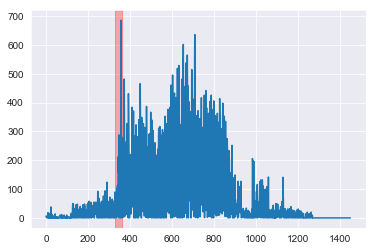

In [906]:
dec_array = gen_activity_graph(G_mapped, Gc_dec)

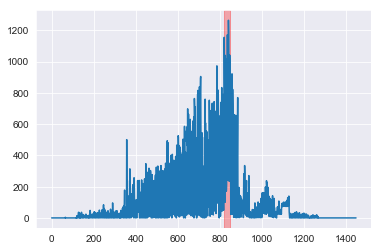

In [907]:
apr_array = gen_activity_graph(G_mapped, Gc_apr)

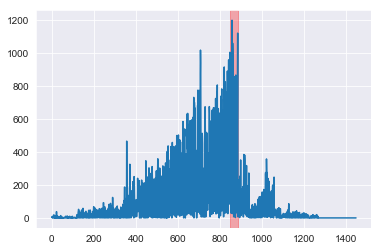

In [908]:
may_array = gen_activity_graph(G_mapped, Gc_may)

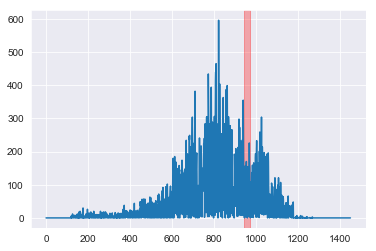

In [942]:
aug_array = gen_activity_graph(G_mapped, Gc_aug)

In [190]:
id_email = pd.read_csv('id-email.csv', header=None, names=['id','email'], index_col='id')
id_email.head()

,email
id,
0,1800flowers@shop2u.com
1,2000greetings@postalmanager.com
2,2740741@skytel.com
3,40ees@enron.com
4,40enron@enron.com


In [553]:
apr_emails = [email for email in map(lambda x: id_email.loc[x]['email'], Gc_apr.nodes)]
print(f'April emails: {apr_emails}')

April emails: ['chris.germany@enron.com', 'sgovenar@govadv.com', 'debra.perlingiere@enron.com', 'becky.spencer@enron.com', 'mary.cook@enron.com', 'janel.guerrero@enron.com', 'rhonda.denton@enron.com', 'bill.iii@enron.com', 'matthew.lenhart@enron.com', 'richard.sanders@enron.com', 'richard.shapiro@enron.com', 'tori.kuykendall@enron.com', 'outlook.team@enron.com', 'jeff.dasovich@enron.com', 'alan.comnes@enron.com', 'drew.fossum@enron.com', 'patrice.mims@enron.com', 'karen.denne@enron.com', 'stanley.horton@enron.com', 'kate.symes@enron.com', 'veronica.espinoza@enron.com', 'michael.tribolet@enron.com', 'vince.kaminski@enron.com', 'kay.mann@enron.com', 'steven.kean@enron.com', 'pete.davis@enron.com', 'dan.hyvl@enron.com', 'elizabeth.sager@enron.com', 'cara.semperger@enron.com', 'phillip.allen@enron.com', 'phillip.love@enron.com', 'mike.mcconnell@enron.com', 'sally.beck@enron.com', 'carol.clair@enron.com', 'susan.mara@enron.com', 'susan.scott@enron.com', 'enron.announcements@enron.com', 'dar

In [554]:
# Set of April emails for official data subtracting the set I got for April
set(['virginia.thompson@enron.com', 'bill.iii@enron.com', 'geir.solberg@enron.com', 'eric.linder@enron.com', 'grace.rodriguez@enron.com', 'mark.palmer@enron.com', 'amy.fitzpatrick@enron.com', 'reagan.rorschach@enron.com', 'jennifer.rudolph@enron.com', 'mark.confer@enron.com', 'pete.davis@enron.com', 'david.fairley@enron.com', 'crystal.hyde@enron.com', 'steve.hall@enron.com', 'donna.johnson@enron.com', 'sean.crandall@enron.com', 'brian.redmond@enron.com', 'david.porter@enron.com', 'cara.semperger@enron.com', 'richard.lydecker@enron.com', 'greg.wolfe@enron.com', 'robert.neustaedter@enron.com', 'scott.stoness@enron.com', 'janel.guerrero@enron.com', 'jbennett@gmssr.com']) - set(apr_emails)

{'amy.fitzpatrick@enron.com',
 'brian.redmond@enron.com',
 'crystal.hyde@enron.com',
 'david.fairley@enron.com',
 'david.porter@enron.com',
 'donna.johnson@enron.com',
 'eric.linder@enron.com',
 'geir.solberg@enron.com',
 'grace.rodriguez@enron.com',
 'greg.wolfe@enron.com',
 'jbennett@gmssr.com',
 'jennifer.rudolph@enron.com',
 'mark.confer@enron.com',
 'mark.palmer@enron.com',
 'reagan.rorschach@enron.com',
 'richard.lydecker@enron.com',
 'robert.neustaedter@enron.com',
 'scott.stoness@enron.com',
 'sean.crandall@enron.com',
 'steve.hall@enron.com',
 'virginia.thompson@enron.com'}

In [555]:
dec_emails = [email for email in map(lambda x: id_email.loc[x]['email'], Gc_dec.nodes)]
print(f'December emails: {dec_emails}')

December emails: ['leslie.hansen@enron.com', 'sara.shackleton@enron.com', 'david.dupre@enron.com', 'vince.kaminski@enron.com', 'david.forster@enron.com', 'molly.harris@enron.com', 'steven.kean@enron.com', 'larry.hunter@enron.com', 'dale.neuner@enron.com', 'gerald.nemec@enron.com', 'tana.jones@enron.com', 'christi.nicolay@enron.com', 'elizabeth.sager@enron.com', 'ginger.dernehl@enron.com', 'twanda.sweet@enron.com', 'mark.haedicke@enron.com', 'sally.beck@enron.com', 'richard.sanders@enron.com', 'susan.scott@enron.com', 'mark.taylor@enron.com', 'lora.sullivan@enron.com', 'eric.bass@enron.com']


In [556]:
# Set of December emails for official data subtracting the set I got for December
set(['vince.kaminski@enron.com', 'sgilles@columbiaenergygroup.com', 'chris.germany@enron.com', 'lauri.allen@enron.com', 'kevin.moore@enron.com', 'mandy.mackinnon@enron.com', 'clayton.vernon@enron.com', 'drew.fossum@enron.com', 'david.dupre@enron.com', 'daren.farmer@enron.com', 'stella.morris@enron.com', 'charlotte.hawkins@enron.com', 'brenda.herod@enron.com', 'howard.camp@enron.com', 'dale.neuner@enron.com', 'eric.bass@enron.com', 'julie.meyers@enron.com', 'kimberly.vaughn@enron.com', 'peter.keavey@enron.com', 'john.lavorato@enron.com', 'ami.chokshi@enron.com', 'christi.nicolay@enron.com', 'sally.beck@enron.com', 'gary.hanks@enron.com', 'randall.gay@enron.com', 'pdrexel@columbiaenergygroup.com', 'twanda.sweet@enron.com', 'mark.haedicke@enron.com', 'carrie.hollomon@enron.com']) - set(dec_emails)

{'ami.chokshi@enron.com',
 'brenda.herod@enron.com',
 'carrie.hollomon@enron.com',
 'charlotte.hawkins@enron.com',
 'chris.germany@enron.com',
 'clayton.vernon@enron.com',
 'daren.farmer@enron.com',
 'drew.fossum@enron.com',
 'gary.hanks@enron.com',
 'howard.camp@enron.com',
 'john.lavorato@enron.com',
 'julie.meyers@enron.com',
 'kevin.moore@enron.com',
 'kimberly.vaughn@enron.com',
 'lauri.allen@enron.com',
 'mandy.mackinnon@enron.com',
 'pdrexel@columbiaenergygroup.com',
 'peter.keavey@enron.com',
 'randall.gay@enron.com',
 'sgilles@columbiaenergygroup.com',
 'stella.morris@enron.com'}

In [804]:
aug_emails = [email for email in map(lambda x: id_email.loc[x]['email'], Gc_aug.nodes)]
print(f'August emails: {aug_emails}')

August emails: ['sgovenar@govadv.com', '40enron@enron.com', 'debra.perlingiere@enron.com', 'john.zufferli@enron.com', 'lorna.brennan@enron.com', 'sylvia.hu@enron.com', 'virginia.thompson@enron.com', 'chris.stokley@enron.com', 'marie.heard@enron.com', 'michelle.cash@enron.com', 'jeff.dasovich@enron.com', 'gerald.nemec@enron.com', 'jonathan.mckay@enron.com', 'monika.causholli@enron.com', 'michelle.lokay@enron.com', 'tim.belden@enron.com', 'kimberly.watson@enron.com', 'stacey.bolton@enron.com', 'alan.comnes@enron.com', 'diana.scholtes@enron.com', 'elizabeth.sager@enron.com', 'lynn.blair@enron.com', 'john.arnold@enron.com', 'glen.hass@enron.com', 'ken.powers@enron.com', 'dutch.quigley@enron.com', 'lisa.jacobson@enron.com', 'j.kaminski@enron.com', 'grace.rodriguez@enron.com', 'susan.mara@enron.com', 'kate.symes@enron.com', 'bill.williams@enron.com', 'darrell.schoolcraft@enron.com', 'paul.kaufman@enron.com', 'chris.dorland@enron.com']


In [806]:
# Set of August emails for official data subtracting the set I got for August
set(['40enron@enron.com', 'john.sturn@enron.com', 'gretchen.hardeway@enron.com', 'greg.mann@enron.com', 'j.kaminski@enron.com', 'dave.perrino@enron.com', 'kimberly.watson@enron.com', 'larry.pavlou@enron.com', 'ron.matthews@enron.com', 'greg.frers@enron.com', 'ken.powers@enron.com', 'magdelena.cruz@enron.com', 'john.zufferli@enron.com', 'paul.donnelly@bakeratlas.com', 'ketchekl@bp.com', 'diana.scholtes@enron.com', 'jean.mrha@enron.com', 'eric.faucheaux@enron.com', 'bill.williams@enron.com', 'payables.ibuyit@enron.com', 'jeanie.slone@enron.com', 'monika.causholli@enron.com', 'tuckiejeff@hotmail.com', 'chris.stokley@enron.com', 'holden.salisbury@enron.com', 'jonathan.mckay@enron.com', 'dee.espinoza@travelpark.com', 'margaret.daffin@enron.com']) - set(aug_emails)

{'dave.perrino@enron.com',
 'dee.espinoza@travelpark.com',
 'eric.faucheaux@enron.com',
 'greg.frers@enron.com',
 'greg.mann@enron.com',
 'gretchen.hardeway@enron.com',
 'holden.salisbury@enron.com',
 'jean.mrha@enron.com',
 'jeanie.slone@enron.com',
 'john.sturn@enron.com',
 'ketchekl@bp.com',
 'larry.pavlou@enron.com',
 'magdelena.cruz@enron.com',
 'margaret.daffin@enron.com',
 'paul.donnelly@bakeratlas.com',
 'payables.ibuyit@enron.com',
 'ron.matthews@enron.com',
 'tuckiejeff@hotmail.com'}

In [943]:
set(apr_emails)&set(aug_emails)#&set(['40enron@enron.com', 'john.sturn@enron.com', 'gretchen.hardeway@enron.com', 'greg.mann@enron.com', 'j.kaminski@enron.com', 'dave.perrino@enron.com', 'kimberly.watson@enron.com', 'larry.pavlou@enron.com', 'ron.matthews@enron.com', 'greg.frers@enron.com', 'ken.powers@enron.com', 'magdelena.cruz@enron.com', 'john.zufferli@enron.com', 'paul.donnelly@bakeratlas.com', 'ketchekl@bp.com', 'diana.scholtes@enron.com', 'jean.mrha@enron.com', 'eric.faucheaux@enron.com', 'bill.williams@enron.com', 'payables.ibuyit@enron.com', 'jeanie.slone@enron.com', 'monika.causholli@enron.com', 'tuckiejeff@hotmail.com', 'chris.stokley@enron.com', 'holden.salisbury@enron.com', 'jonathan.mckay@enron.com', 'dee.espinoza@travelpark.com', 'margaret.daffin@enron.com'])

{'alan.comnes@enron.com',
 'debra.perlingiere@enron.com',
 'elizabeth.sager@enron.com',
 'jeff.dasovich@enron.com',
 'john.arnold@enron.com',
 'kate.symes@enron.com',
 'sgovenar@govadv.com',
 'susan.mara@enron.com'}

In [750]:
set(dec_emails)&set(apr_emails)

{'elizabeth.sager@enron.com',
 'richard.sanders@enron.com',
 'sally.beck@enron.com',
 'sara.shackleton@enron.com',
 'steven.kean@enron.com',
 'susan.scott@enron.com',
 'tana.jones@enron.com',
 'vince.kaminski@enron.com'}